SEÑALES ELÉCTRICAS      
    
     Ejercicios Tema 7

**Objectivo**: Practicar numéricamente con la integral de convolución, su interpretación gráfica y su utilidad en los procesos de filtrado.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.interpolation import shift
from scipy.fft import ifft, fft
from scipy.signal import freqs, iirfilter, square

from typing import Union, List, Tuple
from IPython.display import Audio

C:\Users\Juan Gerez Jimenez\AppData\Local\Temp\ipykernel_7108\1732967814.py:4: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


# Funciones Auxiliares

In [5]:
def obtener_pulso_rectangular(periodo: Union[float, int], vector_temporal: np.ndarray, ciclo_de_trabajo: float, es_centrado: bool = False) -> np.ndarray:
    """Obtener un pulso rectangular

    Parameters
    ----------
    periodo: Union[float, int]
      Periodo del pulso rectangular
    vector_temporal: np.ndarray
      Eje temporal del pulso rectangular
    ciclo_de_trabajo: float
      Ciclo de trabajo esperado
    es_centrado: Optional[bool] = False
      Indica si el pulso rectangular está centrado o no en el origen

    Returns
    -------
    np.ndarray
      Pulso rectangular deseado
    """
    voltaje_inferior = 0

    senial = square((2*np.pi*1/periodo)*vector_temporal, duty=ciclo_de_trabajo)
    senial[senial < 0] = voltaje_inferior

    if es_centrado:
      senial = shift(senial, senial.size*(1-ciclo_de_trabajo)/2, cval=voltaje_inferior)

    return senial

In [6]:
def obtener_funcion_deseada(pares_ordenados: List[Tuple[int, int]], cantidad_puntos_por_ciclo: int) -> Tuple[np.ndarray, np.ndarray, int]:
    """Obtener una función deseada a partes de un conjunto de pares ordenados

    Parameters
    ----------
    pares_ordenados : List[Tuple[int, int]]
        Pares ordenados que se desean satisfacer en la función deseada
    cantidad_puntos_por_ciclo : int
        Cantidad de muestras totales que se desea de la función

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Tupla con primer elemento con valores del eje de abscisa y segundo elemento con valores del eje de ordenadas
    """
    x_max = np.max([x for x, y in pares_ordenados])
    x_min = np.min([x for x, y in pares_ordenados])

    vector_y = [y for x, y in pares_ordenados]

    senial_en_x = np.linspace(start=x_min, stop=x_max, num=cantidad_puntos_por_ciclo)

    senial_en_y = []

    for index in range(len(pares_ordenados)):
      if index == 0:
        senial_en_y.append(pares_ordenados[index][1])
      elif index == len(pares_ordenados) - 1:
        continue

      pendiente = (pares_ordenados[index + 1][1] - pares_ordenados[index][1]) / (pares_ordenados[index + 1][0] - pares_ordenados[index][0])

      for muestra_temporal in senial_en_x:
        if pares_ordenados[index][0] <= muestra_temporal and muestra_temporal < pares_ordenados[index + 1][0]:
          senial_en_y.append(senial_en_y[-1] + pendiente * (x_max - x_min)/vector_muestras_temporal.size)

    return np.array(senial_en_y)

# Ejercicio 1 B

Use el archivo .ipynb compartido por la cátedra para visualizar el producto de convolución de un pulso rectangular y una señal con forma de "aleta de tiburón".

In [7]:
# Definición de variables

periodo = 2  # segundos
frecuencia_muestreo = 1e3
total_samples = int(periodo * frecuencia_muestreo)

In [8]:
# Generación de vector con muestras temporales

vector_muestras_temporal = np.arange(0, periodo, 1/frecuencia_muestreo)

In [9]:
# Generación de Puslo rectangular

pulso_rectangular = obtener_pulso_rectangular(  # Usar la función dada como Función Auxiliar
    periodo=periodo,
    vector_temporal=vector_muestras_temporal,
    ciclo_de_trabajo=0.5,
    es_centrado=False
)

In [10]:
# Generación de Aleta de Tiburón

pares_ordenados = [
  (0, 0),
  (5, 1),
  (5.0001, 0)
]

aleta_tiburon = obtener_funcion_deseada(
    pares_ordenados=pares_ordenados,
    cantidad_puntos_por_ciclo=vector_muestras_temporal.size
)

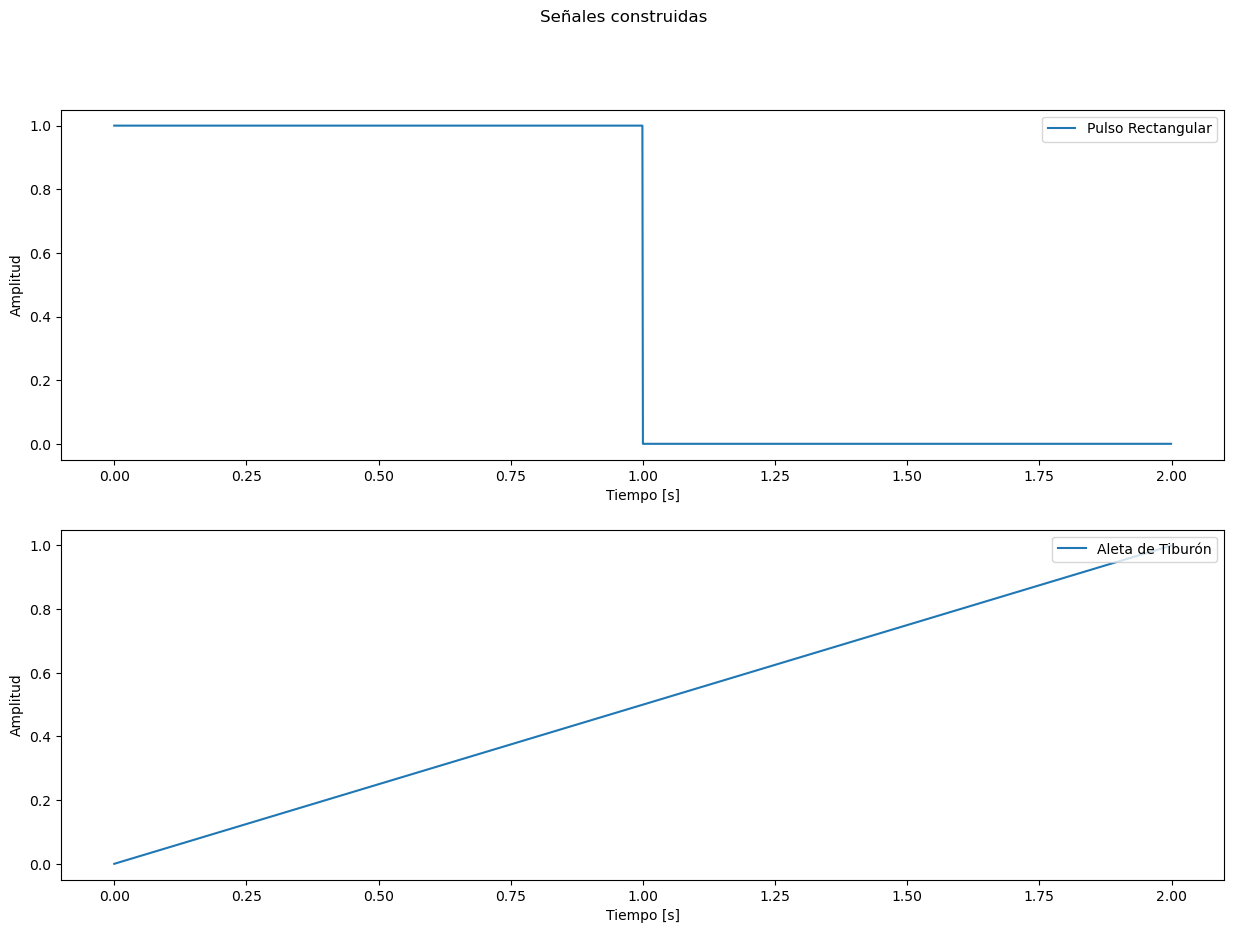

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 10)
fig.suptitle("Señales construidas")

ax1.plot(vector_muestras_temporal, pulso_rectangular, label="Pulso Rectangular")
ax1.legend(loc="upper right")
ax1.set_ylabel("Amplitud")
ax1.set_xlabel("Tiempo [s]")

ax2.plot(vector_muestras_temporal, aleta_tiburon, label="Aleta de Tiburón")
ax2.legend(loc="upper right")
ax2.set_ylabel("Amplitud")
ax2.set_xlabel("Tiempo [s]")

plt.show()

In [12]:
def obtener_convolucion(senial_1: np.ndarray, senial_2: np.ndarray, vector_temporal_senial_1: np.ndarray, vector_temporal_senial_2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """
  Obtengo la convolución entre dos señales NO contemplando señales no causales

  Parameters
  ----------
  senial_1: np.ndarray
    Señal 1 a convolucionar
  senial_2: np.ndarray
    Señal 2 a convolucionar
  vector_temporal_senial_1: np.ndarray
    Vector con muestras temporales de señal 1
  vector_temporal_senial_2: np.ndarray
    Vector con muestras temporales de señal 2

  Returns
  -------
  Tuple[np.ndarray, np.ndarray]
    Eje temporal de convolución y resultado de convolución de señales.
  """
  senial_2_invertida = np.flip(senial_2)  # senial[::-1]

  # np.pad(): https://numpy.org/doc/stable/reference/generated/numpy.pad.html
  senial_1_completa = np.pad(senial_1, (len(senial_2) - 1, 0), 'constant')
  senial_2_completa = np.pad(senial_2_invertida, (0, len(senial_1) - 1), 'constant')

  convolucion_vector = []
  for shift_amount in range(senial_1_completa.size):  # de 0 a N1+N2-2
    senial_2_shift = shift(senial_2_completa, shift=shift_amount, cval=0)
    valor_producto_punto = np.dot(senial_1_completa, senial_2_shift)
    convolucion_vector.append(valor_producto_punto)

  # generar eje temporal desde t=0 hasta t = T1 + T2 - 2*Ts
  eje_temporal = np.linspace(
      start=0,
      stop=vector_temporal_senial_1[-1] + vector_temporal_senial_2[-1],
      num=len(convolucion_vector)
  )
  return eje_temporal, np.array(convolucion_vector)

In [13]:
# Uso de función para obtener convolución

eje_temporal, convolucion_resultado = obtener_convolucion(
    senial_1=pulso_rectangular,
    senial_2=aleta_tiburon,
    vector_temporal_senial_1=vector_muestras_temporal,
    vector_temporal_senial_2=vector_muestras_temporal
)

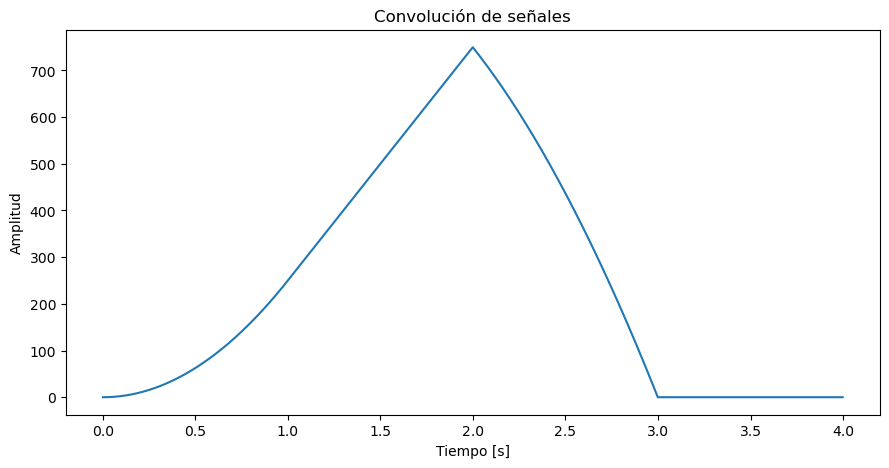

In [14]:
# Grafica de la convolución

fig = plt.gcf()
fig.set_size_inches(10.5, 5)

plt.title("Convolución de señales")
plt.plot(eje_temporal, convolucion_resultado)  # trazo de tiempo vs amplitud de la convolución
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.show()

Verifique la conmutatividad del proceso de convolución.

In [15]:
# Uso de función para obtener convolución con señales conmutada

eje_temporal_conmutado, convolucion_resultado_conmutada = obtener_convolucion(
    senial_1=aleta_tiburon,
    senial_2=pulso_rectangular,
    vector_temporal_senial_1=vector_muestras_temporal,
    vector_temporal_senial_2=vector_muestras_temporal
)

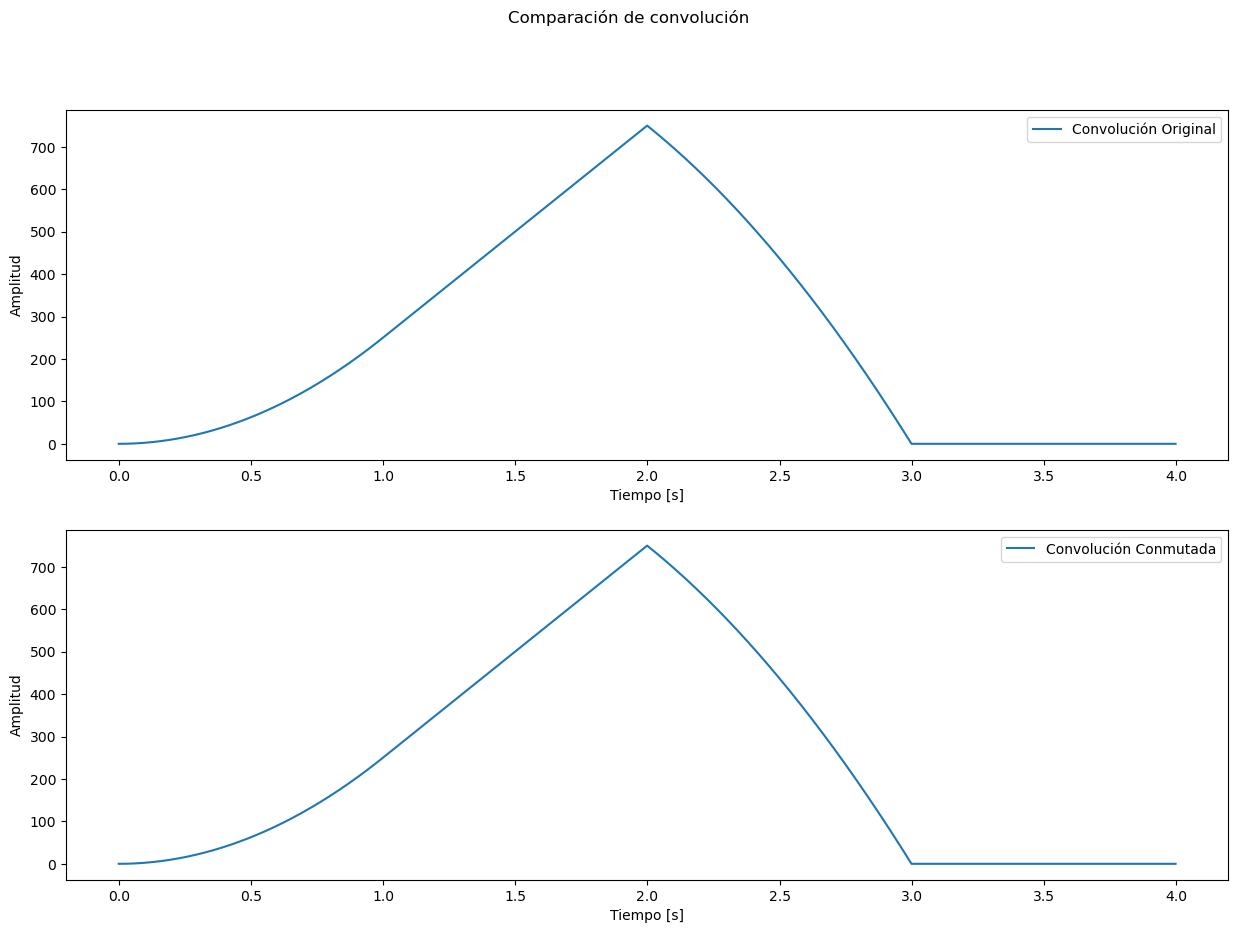

In [16]:
# Grafica comparativa de convolución conmutada

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 10)
fig.suptitle("Comparación de convolución")

ax1.plot(eje_temporal, convolucion_resultado, label="Convolución Original")
ax1.legend(loc="upper right")
ax1.set_ylabel("Amplitud")
ax1.set_xlabel("Tiempo [s]")

ax2.plot(eje_temporal_conmutado, convolucion_resultado_conmutada, label="Convolución Conmutada")
ax2.legend(loc="upper right")
ax2.set_ylabel("Amplitud")
ax2.set_xlabel("Tiempo [s]")

plt.show()

Verifique que la operatoria para señales no-causales y para las causales es la misma.


In [17]:
# Armado de función no causal

pares_ordenados_no_causal = [
  (-2, 0),   # inicio en t = -2 con amplitud 0
  (-1, 1),   # en t = -1 sube a amplitud 1
  (0, 1),    # en t = 0 mantiene amplitud 1
  (1, 2),    # en t = 1 sube a amplitud 2
  (2, 1),    # en t = 2 baja a amplitud 1
  (3, 0)     # en t = 3 vuelve a 0
]

vector_temporal_no_causal = np.linspace(
    start=np.min([x for x, y in pares_ordenados_no_causal]),  # tiempo mínimo (-2)
    stop=np.max([x for x, y in pares_ordenados_no_causal]),   # tiempo máximo (3)
    num=vector_muestras_temporal.size                         # mismo número de muestras que antes
)

senial_no_causal = obtener_funcion_deseada(
    pares_ordenados=pares_ordenados_no_causal,                  # pares definidos
    cantidad_puntos_por_ciclo=vector_temporal_no_causal.size    # puntos por ciclo según vector no causal
)

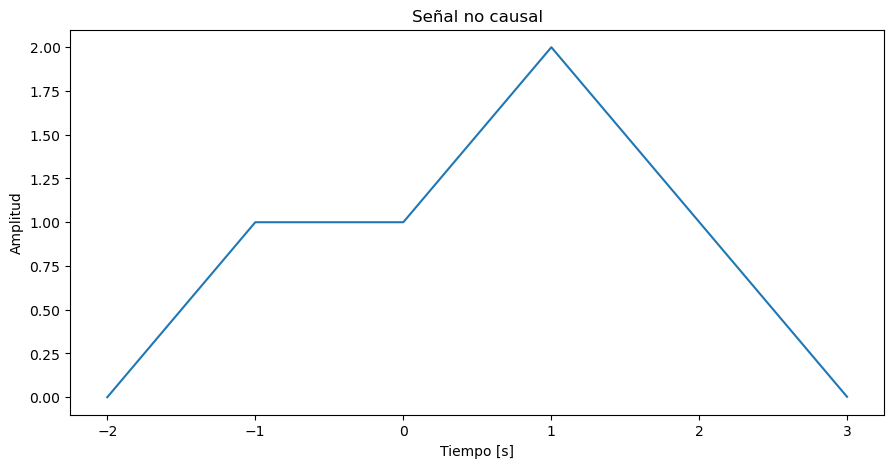

In [18]:
# Gráfica función no causal

fig = plt.gcf()
fig.set_size_inches(10.5, 5)

plt.title("Señal no causal")
plt.plot(vector_temporal_no_causal, senial_no_causal)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()

In [19]:
# Uso de función para obtener convolución con señales no causal

eje_temporal_no_causal, convolucion_resultado_no_causal = obtener_convolucion(  # Uso señal dada por la cátedra para obtener convolución
    senial_1=senial_no_causal,
    senial_2=senial_no_causal,
    vector_temporal_senial_1=vector_temporal_no_causal,
    vector_temporal_senial_2=vector_temporal_no_causal
)

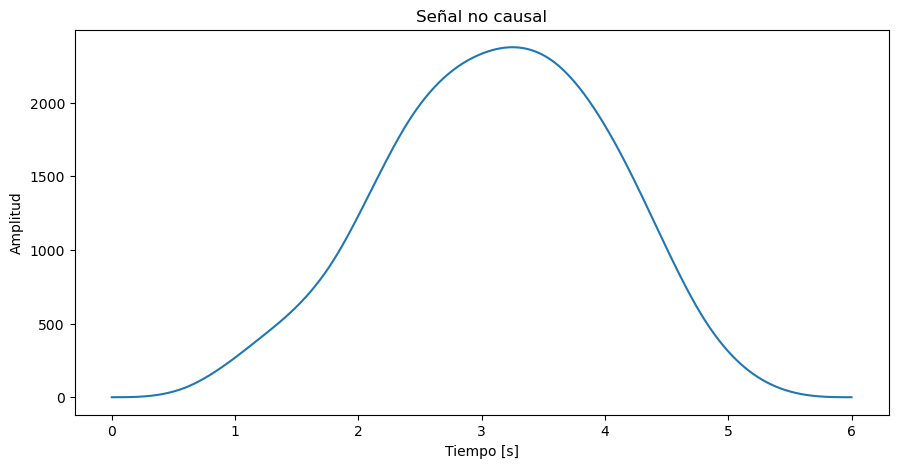

In [20]:
# Gráfica de resultado convolución con señal no causal

fig = plt.gcf()
fig.set_size_inches(10.5, 5)

plt.title("Señal no causal")
plt.plot(eje_temporal_no_causal, convolucion_resultado_no_causal)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()

Pruebe con otras señales también. Para construir las señales a convolucionar puede usar el método compartido por la cátedra llamado obtener_funcion_deseada().

(A completar por el alumno)

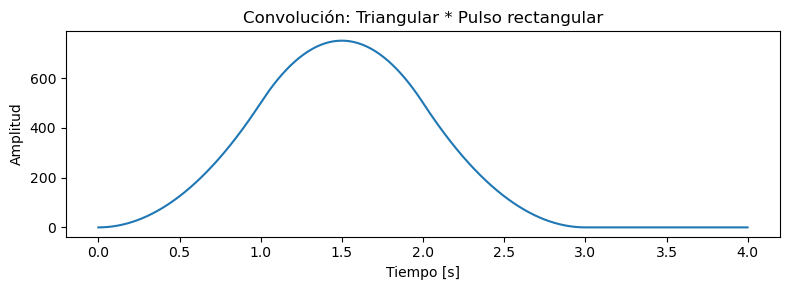

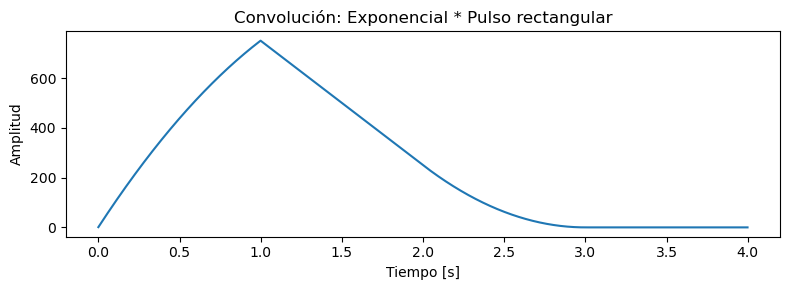

In [21]:
# Número de puntos y eje temporal común
N = vector_muestras_temporal.size
t = vector_muestras_temporal

# 1) Señal triangular
pares_triangular = [(0, 0), (0.5, 1), (1, 0)]
triangular = obtener_funcion_deseada(pares_triangular, cantidad_puntos_por_ciclo=N)

# 2) Señal exponencial decreciente
pares_exp = [(0, 1), (1, 0)]
exp_decreciente = obtener_funcion_deseada(pares_exp, cantidad_puntos_por_ciclo=N)

# Convolucionar cada par con, por ejemplo, el pulso rectangular
for sig, nombre in [(triangular, "Triangular"), (exp_decreciente, "Exponencial")]:
    eje, y = obtener_convolucion(sig, pulso_rectangular, t, t)
    plt.figure(figsize=(8,3))
    plt.title(f"Convolución: {nombre} * Pulso rectangular")
    plt.plot(eje, y)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.tight_layout()
    plt.show()


EJERCICIO 1A

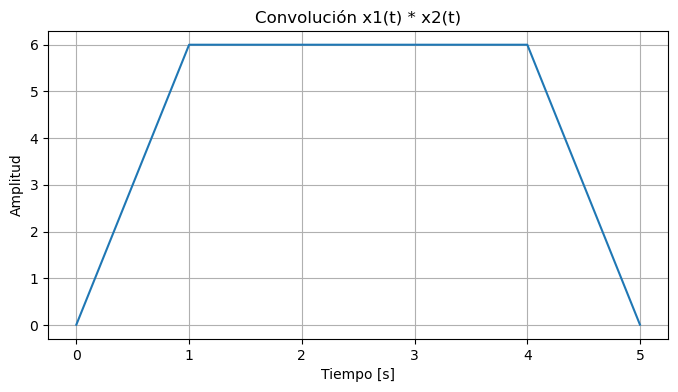

In [22]:
# Parámetros de muestreo
fs = 1000        # frecuencia de muestreo en Hz
dt = 1 / fs      # paso de tiempo

# Señal x1(t): pulso de amplitud 3 en [1, 2)
t1 = np.arange(1, 2, dt)
x1 = 3 * np.ones_like(t1)

# Señal x2(t): pulso de amplitud 2 en [-1, 3)
t2 = np.arange(-1, 3, dt)
x2 = 2 * np.ones_like(t2)

# Convolución discreta (integral aproximada)
y = np.convolve(x1, x2) * dt

# Eje temporal del resultado: empieza en t1[0]+t2[0], termina en t1[-1]+t2[-1]
t_y_start = t1[0] + t2[0]
t_y_end   = t1[-1] + t2[-1]
t_y = np.arange(t_y_start, t_y_end + dt, dt)[:len(y)]

# Graficar
plt.figure(figsize=(8,4))
plt.plot(t_y, y)
plt.title("Convolución x1(t) * x2(t)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


# Ejercicio 2


¿Cómo modificaría el método obtener_convolucion() para colocar correctamente el eje del tiempo cuando alguna de las señales convolucionadas es no-causal?

In [50]:
def obtener_convolucion_modificado(senial_1: np.ndarray, senial_2: np.ndarray, vector_temporal_senial_1: np.ndarray, vector_temporal_senial_2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """
  Obtengo la convolución entre dos señales SI contemplando señales no causales

  Parameters
  ----------
  senial_1: np.ndarray
    Señal 1 a convolucionar
  senial_2: np.ndarray
    Señal 2 a convolucionar
  vector_temporal_senial_1: np.ndarray
    Vector con muestras temporales de señal 1
  vector_temporal_senial_2: np.ndarray
    Vector con muestras temporales de señal 2

  Returns
  -------
  Tuple[np.ndarray, np.ndarray]
    Eje temporal de convolución y resultado de convolución de señales.
  """
  senial_2_invertida = np.flip(senial_2)

  # np.pad(): https://numpy.org/doc/stable/reference/generated/numpy.pad.html
  senial_1_completa = np.pad(senial_1, (len(senial_2) - 1, 0), 'constant')
  senial_2_completa = np.pad(senial_2_invertida, (0, len(senial_1) - 1), 'constant')

  convolucion_vector = []
  for shift_amount in range(senial_1_completa.size):  # [0, 1, ..., N1+N2-2]
        senial_2_shift = shift(senial_2_completa, shift=shift_amount, cval=0)
        valor_producto_punto = np.dot(senial_1_completa, senial_2_shift)
        convolucion_vector.append(valor_producto_punto)

    # Para señales no causales:
    # Calcular t_inicio = min(t1) + min(t2) y t_final = max(t1) + max(t2)
  t_inicio = np.min(vector_temporal_senial_1) + np.min(vector_temporal_senial_2)
  t_final  = np.max(vector_temporal_senial_1) + np.max(vector_temporal_senial_2)

  eje_temporal = np.linspace(
        start=t_inicio,
        stop=t_final,
        num=len(convolucion_vector)
    )
  return eje_temporal, np.array(convolucion_vector)

In [51]:
# Uso de función para obtener convolución con señales no causal

eje_temporal_no_causal_mod, convolucion_resultado_no_causal_mod = obtener_convolucion_modificado(
    senial_1=pulso_rectangular,
    senial_2=senial_no_causal,
    vector_temporal_senial_1=vector_muestras_temporal,
    vector_temporal_senial_2=vector_temporal_no_causal
)

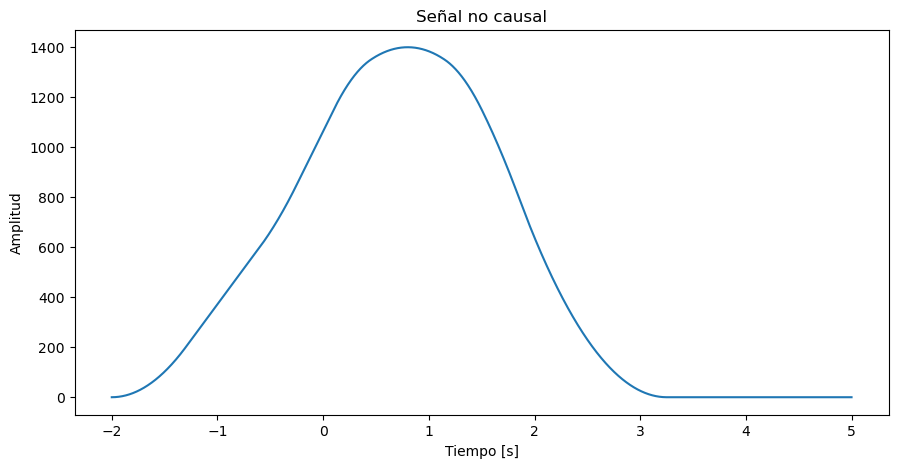

In [52]:
# Gráfica de resultado convolución con señal no causal con método modificado

fig = plt.gcf()
fig.set_size_inches(10.5, 5)

plt.title("Señal no causal")
plt.plot(eje_temporal_no_causal_mod, convolucion_resultado_no_causal_mod)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.show()

# Ejercicio 3

a) Construya los vectores de tiempo y amplitud correspondientes a una señal senoidal de 1kHz de 200ms de duración y, una frecuencia de muestreo de 8192Hz. Use la función "sound" del Octave Matlab para escuchar la señal.

In [27]:
# Defino variables de interés

frecuencia_muestreo =      8192  # Hz
duracion_senial     =    0.2   # segundos = 200 ms
frecuencia          =    1000    # Hz

In [28]:
# Generación de señal pedida

vector_tiempo_3 = np.arange(
    start=0,
    stop=duracion_senial,
    step=1/frecuencia_muestreo
)
senial_3 = np.sin(2 * np.pi * frecuencia * vector_tiempo_3)

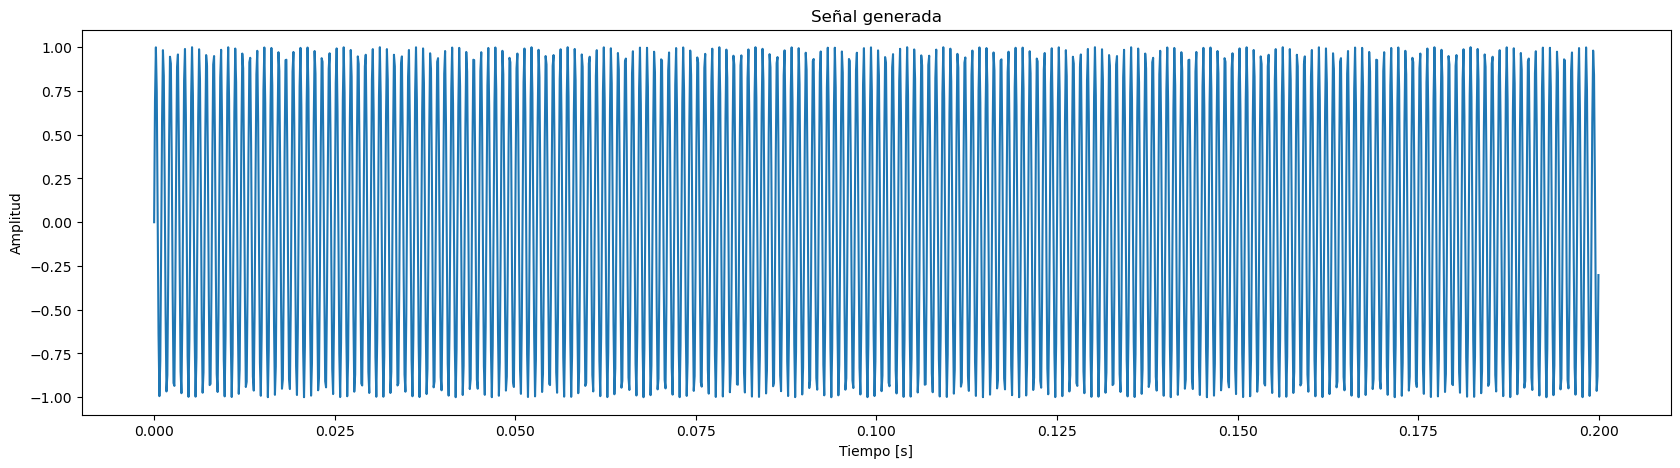

In [29]:
# Grafica señal generada

fig = plt.gcf()
fig.set_size_inches(20.5, 5)

plt.title("Señal generada")

plt.plot(vector_tiempo_3, senial_3)

plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.show()

In [30]:
# Reproducción señal generada

Audio(senial_3, rate=frecuencia_muestreo)

b) Genere un vector de 30 mil elementos con la función "randn". En la zona media del vector súmele una onda senoidal de 1kHz y 200ms de duración, que tenga la misma potencia media que el ruido. Escuche el resultado de la mezcla.

In [31]:
cantidad_elementos = 30000

# Recomendamos utilizar método randn() de la librería numpy
senial_ruidosa = np.random.randn(cantidad_elementos)  # genera vector de ruido gaussiano de 30000 muestras

In [32]:
# Calculo potencia del ruido generado
valor_medio_ruido   = np.mean(senial_ruidosa)
valor_eficaz_ac_ruido = np.sqrt(np.mean((senial_ruidosa - valor_medio_ruido)**2))
valor_eficaz_ruido    = np.sqrt(np.mean(senial_ruidosa**2))

print(f"El valor eficaz estadístico de la señal ruidosa: {valor_eficaz_ruido}")

El valor eficaz estadístico de la señal ruidosa: 0.9968353476524451


Para una señal senoidal, se sabe que

$V_{ef} = \frac{A}{\sqrt{2}} $

Por lo que si queremos respetar un Valor Eficaz, debemos definir la amplitud de esta señal como:

$ A = V_{ef} * \sqrt{2} $

In [33]:
# Hago que el valor eficaz de la señal senoida sea igual a la del ruido

amplitud_senial_3_modificada = valor_eficaz_ruido / np.sqrt(np.mean(senial_3**2))

senial_3_modificada = senial_3 * amplitud_senial_3_modificada  # escalo la amplitud de la señal

valor_medio_senial_modificada = np.mean(senial_3_modificada)
valor_eficaz_ac_senial_modificada = np.sqrt(np.mean((senial_3_modificada - valor_medio_senial_modificada)**2))
valor_eficaz_senial_modificada = np.sqrt(np.mean(senial_3_modificada**2))

print(f"El valor eficaz estadístico de la señal senoidal modificada: {valor_eficaz_senial_modificada}")

El valor eficaz estadístico de la señal senoidal modificada: 0.996835347652445


In [34]:
# Armado de señal para ser sumada


diferencia_muestras_seniales = senial_ruidosa.size - senial_3_modificada.size
pad_left  = diferencia_muestras_seniales // 2
pad_right = diferencia_muestras_seniales - pad_left

senial_3_modificada_pad = np.pad(
    senial_3_modificada,
    (pad_left, pad_right),
    'constant'
)

In [35]:
# Armado de señal compuesta y reproducción

senial_compuesta = senial_ruidosa + senial_3_modificada_pad
Audio(senial_compuesta, rate=frecuencia_muestreo)

c) Repita el procedimiento anterior reduciendo paulatinamente la intensidad de la senoidal hasta 14dB por debajo del nivel de ruido. ¿Cuánto vale la relación señal/ruido?

Necesito lograr que el valor_eficaz de mi señal sea 14 dB menor que la señal de interés.

Es decir que, necesito satisfacer la siguiente igualdad:

$ diferencia\_db\ [db] = 10 log(\frac{P_{ruido}}{P_{audio}}) $

De esta manera, la potencia de ruido vendrá dada por la siguiente ecuación:

$ P_{ruido} = 10^{\frac{diferencia\_db}{10}} P_{audio} $

In [36]:
# Cálculo de valor eficaz necesario en señal senoidal

diferencia_potencia       = 14  # dB (señal 14 dB por debajo del ruido)

valor_eficaz_necesario    = valor_eficaz_ruido * 10**(-diferencia_potencia/20)

print(f"El valor eficaz necesario es: {valor_eficaz_necesario}")

El valor eficaz necesario es: 0.19889480033998255


In [37]:
# Cálculo de señal atenuada

amplitud_senial_3_atenuada      = valor_eficaz_necesario / np.sqrt(np.mean(senial_3**2))
senial_3_atenuada               = senial_3 * amplitud_senial_3_atenuada

valor_medio_senial_atenuada     = np.mean(senial_3_atenuada)
valor_eficaz_ac_senial_atenuada = np.sqrt(np.mean((senial_3_atenuada - valor_medio_senial_atenuada)**2))
valor_eficaz_senial_atenuada    = np.sqrt(np.mean(senial_3_atenuada**2))

print(f"El valor eficaz estadístico de la señal senoidal modificada: {valor_eficaz_senial_atenuada}")

El valor eficaz estadístico de la señal senoidal modificada: 0.19889480033998255


In [38]:
# Relación señal/ruido en dB
snr = 20 * np.log10(valor_eficaz_senial_atenuada / valor_eficaz_ruido)
print(f"Relación señal/ruido: {snr:.2f} dB")

Relación señal/ruido: -14.00 dB


In [39]:
# Armado de señal para ser sumada

diferencia_muestras_seniales_atenuada = senial_ruidosa.size - senial_3_atenuada.size
pad_left  = diferencia_muestras_seniales_atenuada // 2
pad_right = diferencia_muestras_seniales_atenuada - pad_left

senial_3_atenuada_pad = np.pad(
    senial_3_atenuada,
    (pad_left, pad_right),
    'constant'
)

In [40]:
# Armado de señal compuesta y reproducción

senial_atenuada_compuesta = senial_ruidosa + senial_3_atenuada_pad

Audio(senial_atenuada_compuesta, rate=frecuencia_muestreo)

Cálculo de Relación Señal-Ruido

Para el cálculo de la Relación Señal-Ruido se  debe considerar la siguiente expresión:

$SNR = \frac{Potencia senial}{Potencia ruido}$

Si evaluamos esta señal en dB, tenemos lo siguiente:

$SNR[dB] = 10 log_{10}(Potencia\ senial) - 10 log_{10}(Potencia\ Ruido)$

Equivalente a:

$SNR[dB] = Potencia\ senial\ [dB] - Potencia\ Ruido\ [dB]$

En nuestro ejemplo,

$Potencia\ senial [dB] = Potencia\ Ruido\ [dB] - 14\ [dB]$

Por lo tanto,

$SNR[dB] = Potencia\ senial\ [dB] - Potencia\ Ruido\ [dB]$

$SNR[dB] = (Potencia\ Ruido\ [dB] - 14\ [dB]) -  Potencia\ Ruido\ [dB]$

$SNR[dB] = - 14\ [dB]$

d) Procese las señales compuestas del ítem anterior,

i) convolucionando con la respuesta de un filtro pasabanda centrado en 1kHz

In [41]:
# Filtro PasaBanda con fo=1kHz y AB=10Hz

respuesta_temporal_filtro = 62.8 * np.exp(-31.4 * vector_tiempo_3)*np.cos(2*np.pi*1000*vector_tiempo_3 + 0.6/57.3)

In [42]:
# Convolución Filtro y Señal compuesta

eje_temporal_filtro, convolucion_filtro = obtener_convolucion(  # Use la función compartida por la cátedra
    senial_1=senial_atenuada_compuesta,
    senial_2=respuesta_temporal_filtro,
    vector_temporal_senial_1=vector_muestras_temporal,
    vector_temporal_senial_2=vector_tiempo_3
)

In [43]:
# Reproducción señal filtrada

# Utilice el método Audio
Audio(convolucion_filtro, rate=frecuencia_muestreo)

ii) Encontrando la correlación cruzada entre la señal compuesta y una senoidal de 1kHz y 200ms de duración mediante el uso del método obtener_correlacion_cruzada()

In [44]:
def obtener_correlacion_cruzada(senial_1: np.ndarray,
                                senial_2: np.ndarray,
                                vector_temporal_senial_1: np.ndarray,
                                vector_temporal_senial_2: np.ndarray
                               ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Obtengo la correlación entre dos señales

    Parameters
    ----------
    senial_1: np.ndarray
      Señal 1 a correlacionar
    senial_2: np.ndarray
      Señal 2 a correlacionar
    vector_temporal_senial_1: np.ndarray
      Vector con muestras temporales de señal 1
    vector_temporal_senial_2: np.ndarray
      Vector con muestras temporales de señal 2

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
      Eje temporal de correlación y resultado de correlación de señales.
    """
    # Invertir la segunda señal para correlación cruzada
    senial_2_invertida = np.flip(senial_2)

    # Extender ambas señales para permitir todos los desplazamientos
    senial_1_completa = np.pad(senial_1, (len(senial_2) - 1, 0), 'constant')
    senial_2_completa = np.pad(senial_2_invertida, (0, len(senial_1) - 1), 'constant')

    correlacion_vector = []
    for shift_amount in range(senial_1_completa.size):  # [0, 1, ..., N1+N2-2]
        
        # Desplazar la señal invertida
        senial_2_shift = shift(senial_2_completa, shift=shift_amount, cval=0)

        # Producto punto en cada desplazamiento
        valor_producto_punto = np.dot(senial_1_completa, senial_2_shift)
        correlacion_vector.append(valor_producto_punto)

    
    # Definir eje temporal para la correlación:
    
    # t_inicio = min(t1) - max(t2), t_final = max(t1) - min(t2)
    t_inicio = np.min(vector_temporal_senial_1) - np.max(vector_temporal_senial_2)
    t_final  = np.max(vector_temporal_senial_1) - np.min(vector_temporal_senial_2)

    eje_temporal = np.linspace(
        start=t_inicio,
        stop=t_final,
        num=len(correlacion_vector)
    )

    return eje_temporal, np.array(correlacion_vector)


In [45]:
# Cálculo de correlación cruzada

vector_temporal_senial_compuesta = np.linspace(
    start=0,
    stop=1/frecuencia_muestreo * cantidad_elementos,
    num=cantidad_elementos
)

eje_temporal_correlacion_cruzada, correlacion_cruzada = obtener_correlacion_cruzada(
    senial_1=senial_compuesta,
    senial_2=senial_3,
    vector_temporal_senial_1=vector_temporal_senial_compuesta,
    vector_temporal_senial_2=vector_tiempo_3
)

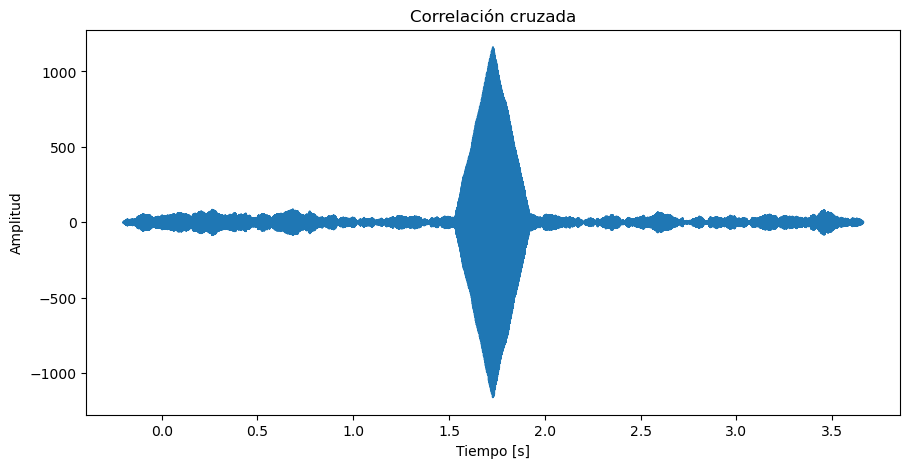

In [46]:
# Gráfico de correlación cruzada

fig = plt.gcf()
fig.set_size_inches(10.5, 5)

plt.title("Correlación cruzada")

plt.plot(eje_temporal_correlacion_cruzada, correlacion_cruzada)

plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.show()

Comente la utilidad de cada uno de los dos tipos de procesamiento.

Convolución con filtro pasa­banda: 

. Extracción de banda de interés: al convolucionar con la respuesta temporal del filtro, se atenúan las componentes fuera de la frecuencia central , dejando solo la porción espectral deseada. 

. Reducción de ruido: el filtro elimina gran parte del ruido fuera de la banda, mejora la relación señal/ruido antes de la escucha o de posteriores análisis. 

. Procesamiento en el dominio del tiempo: se puede obtener directamente la señal filtrada sin recurrir a transformadas si se dispone de la respuesta temporal del sistema.


Correlación cruzada:

. Hallar algo y su demora: Al correlacionar la señal compuesta con la forma senoidal de referencia, se genera un pico en el desfase correspondiente, indicándonos en qué instante aparece la señal que queremos.

. Medicion del tiempo de llegada: Esto es clave para saber los retrasos y alinear señales iguales en sistemas de soncronizacion o en radares.

. No le importa el ruido fuera de fase: La correlación se centra en ver si las formas de onda son iguales, aguantando bien el ruido que no se parece a la referencia.